In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pickle
import os
import sys

from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split

In [2]:
import scanpy as sc
# import scvelo as scv

# read the full GSE dataset
data = sc.read_h5ad('/Users/evanli/Documents/Research_datasets/PBMC_Hao/GSE164378_Hao/Hao_PBMC_GSE164378.h5ad')
# data = sc.read_h5ad(r"C:\Users\evanlee\Documents\Research_datasets\GSE164378\Hao_PBMC_GSE164378.h5ad")
data.shape

(161764, 33538)

In [3]:
### Raw counts were not normalizaed
# CPM
# sc.pp.normalize_total(data, target_sum=1e6)
sc.pp.normalize_total(data, target_sum=None)

# log1p
sc.pp.log1p(data)

In [4]:
data.obs['celltype.l2'] = data.obs['celltype.l2'].str.replace(' ', '_')

label = data.obs['celltype.l2'].tolist()
types = np.unique(label).tolist()
# types = [s.replace(' ', '_') for s in types]
print(types)

['ASDC', 'B_intermediate', 'B_memory', 'B_naive', 'CD14_Mono', 'CD16_Mono', 'CD4_CTL', 'CD4_Naive', 'CD4_Proliferating', 'CD4_TCM', 'CD4_TEM', 'CD8_Naive', 'CD8_Proliferating', 'CD8_TCM', 'CD8_TEM', 'Doublet', 'Eryth', 'HSPC', 'ILC', 'MAIT', 'NK', 'NK_CD56bright', 'NK_Proliferating', 'Plasmablast', 'Platelet', 'Treg', 'cDC1', 'cDC2', 'dnT', 'gdT', 'pDC']


## Read features

In [5]:
# Level 1 ADlasso features by loss difference convergence
import os
# os.chdir(r"C:\Users\evanlee\Documents\GitHub\EvanPys\Progress\PBMC_Hao_GSE\L2_by_lossdiff\feature_selection")
os.chdir('/Users/evanli/Documents/EvanPys/Progress/PBMC_Hao_GSE/L2_by_lossdiff/feature_selection')

features_dict = {}
# Read features for each celltype
for celltype in types:
    try:
        feature_df = pd.read_csv(f'{celltype}_features.txt', names=['Gene', 'Weight', 'Tendency'], sep='\t')
        features_dict[celltype] = feature_df
    except:
        print('skipping:', celltype)
        continue
    # print(celltype, 'Feature count:', feature_df.shape[0])
    # print(celltype, 'Positive feature count:', feature_df[feature_df['Tendency'] == 1].shape[0])
    # print('------------------')

In [6]:
count_df = pd.DataFrame(columns=['Feature_count', 'Positive_feature_count'])
for celltype in features_dict.keys():
    feature_df = features_dict[celltype]
    feature_count = feature_df.shape[0]
    positive_count = feature_df[feature_df['Tendency'] == 1].shape[0]
    count_df.loc[celltype] = [feature_count, positive_count]
count_df

,Feature_count,Positive_feature_count
ASDC,13,0
B_intermediate,19,8
B_memory,35,18
B_naive,8,4
CD14_Mono,15,9
CD16_Mono,11,6
CD4_CTL,111,42
CD4_Naive,124,63
CD4_Proliferating,96,53
CD4_TCM,56,28


## Get likelihood from LR model

In [7]:
def LR_likelihood(data, all_features_dict, celltype):
    print('====================')
    print('Celltype:', celltype)
    # subset data to celltype features
    X = data[:, all_features_dict[celltype]['Gene'].tolist()].X
    # Binary label
    y = [1 if i==celltype else 0 for i in data.obs['celltype.l2'].tolist()]

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0, stratify=y)

    clf = LogisticRegression(penalty='l2', solver='lbfgs', C=1.0, max_iter=1000)
    clf.fit(X_train, y_train)

    decision_scores = clf.decision_function(X)  # >0: predict celltype, <0: predict not celltype
    print('decision_scores > 0:', sum(decision_scores > 0))

    # calculate the likelihood of the positive class for each observation in X based on the decision scores
    likelihood = 1 / (1 + np.exp(-decision_scores))
    print('likelihood > 0.5:', sum(likelihood > 0.5))  # >0.5: predict celltype, <0.5: predict not celltype

    return likelihood


In [ ]:
celltype = 'B_memory'
Bm_likelihood = LR_likelihood(data, features_dict, celltype)
Bm_likelihood.shape

In [ ]:
sum(data.obs['celltype.l2'] == celltype)

In [8]:
likelihood_dict = {}
for celltype in types:
    likelihood_dict[celltype] = LR_likelihood(data, features_dict, celltype)

Celltype: ASDC
decision_scores > 0: 2
likelihood > 0.5: 2
Celltype: B_intermediate
decision_scores > 0: 1793
likelihood > 0.5: 1793
Celltype: B_memory
decision_scores > 0: 3212
likelihood > 0.5: 3212
Celltype: B_naive
decision_scores > 0: 7713
likelihood > 0.5: 7713
Celltype: CD14_Mono
decision_scores > 0: 43049
likelihood > 0.5: 43049
Celltype: CD16_Mono
decision_scores > 0: 6290
likelihood > 0.5: 6290
Celltype: CD4_CTL
decision_scores > 0: 1597
likelihood > 0.5: 1597
Celltype: CD4_Naive
decision_scores > 0: 17235
likelihood > 0.5: 17235
Celltype: CD4_Proliferating
decision_scores > 0: 108
likelihood > 0.5: 108
Celltype: CD4_TCM
decision_scores > 0: 14008
likelihood > 0.5: 14008
Celltype: CD4_TEM
decision_scores > 0: 2006
likelihood > 0.5: 2006
Celltype: CD8_Naive
decision_scores > 0: 10291
likelihood > 0.5: 10291
Celltype: CD8_Proliferating
decision_scores > 0: 58
likelihood > 0.5: 58
Celltype: CD8_TCM
decision_scores > 0: 2456
likelihood > 0.5: 2456
Celltype: CD8_TEM
decision_scores

In [9]:
# turn likelihood_dict into dataframe
likelihood_df = pd.DataFrame(likelihood_dict)
# likelihood_df.insert(0, "Original index", likelihood_df.index)
likelihood_df.head()

,ASDC,B_intermediate,B_memory,B_naive,CD14_Mono,CD16_Mono,CD4_CTL,CD4_Naive,CD4_Proliferating,CD4_TCM,...,NK_CD56bright,NK_Proliferating,Plasmablast,Platelet,Treg,cDC1,cDC2,dnT,gdT,pDC
0,0.000027,0.000010,0.000007,1.955479e-05,9.848602e-01,0.002235,6.465750e-07,2.109563e-09,1.873805e-05,0.000385,...,1.422654e-07,3.946984e-06,0.000003,0.000433,0.001387,3.088006e-07,7.931461e-05,7.711022e-06,4.430510e-07,1.569578e-07
1,0.000487,0.000055,0.000187,2.972656e-06,7.969215e-07,0.000003,1.717024e-06,1.140942e-01,4.096088e-05,0.926804,...,5.989255e-05,8.415305e-08,0.000002,0.000687,0.055736,2.455088e-07,9.736894e-07,2.991105e-04,9.221439e-04,4.441586e-07
2,0.000103,0.000030,0.000014,8.791718e-05,1.714159e-08,0.000005,1.285981e-05,3.689152e-02,3.574752e-07,0.000278,...,1.665692e-05,3.450755e-07,0.000002,0.000330,0.032377,1.031061e-06,5.562957e-07,7.868105e-04,5.487595e-03,6.861813e-07
3,0.000562,0.000047,0.000001,9.103844e-07,1.433661e-06,0.000206,2.134791e-07,1.605797e-06,4.012423e-09,0.000002,...,3.961117e-04,4.415795e-04,0.000003,0.001134,0.009809,2.979876e-06,3.626367e-07,1.980928e-07,2.817434e-02,3.601058e-05
4,0.000129,0.000060,0.000061,1.800164e-05,4.048931e-08,0.000093,1.120689e-06,2.403119e-03,2.591827e-07,0.000519,...,3.571777e-05,3.251042e-07,0.000004,0.000513,0.050339,1.038802e-07,1.838261e-06,1.753908e-03,1.337144e-03,5.061405e-07


In [10]:
likelihood_df.shape

(161764, 31)

In [ ]:
# os.chdir(r"C:\Users\evanlee\Documents\GitHub\EvanPys\Progress\PBMC_Hao_GSE\L2_by_lossdiff\LR_likelihood")

# likelihood_df.to_csv('L2_likelihood_df.csv', index=False)

In [ ]:
# read likelihood_df
# likelihood_df = pd.read_csv('L2_likelihood_df.csv')
# likelihood_df.head()

## (1st_type / 2nd_type) >= 1.5

In [ ]:
# test = likelihood_df.head(1500)
largest_values = []
second_largest_values = []
largest_columns = []
second_largest_columns = []
odds_ratio_list = []
assignments = []

for index, row in likelihood_df.iterrows():
    # find 1st and 2nd largest values and their corresponding columns
    largest_value = row.max()
    largest_column = row.idxmax()
    second_largest_value = row.nlargest(2).iloc[-1]
    second_largest_column = row.nlargest(2).index[-1]
    
    largest_values.append(largest_value)
    second_largest_values.append(second_largest_value)
    largest_columns.append(largest_column)
    second_largest_columns.append(second_largest_column)

    # calculate odds ratio
    odds_ratio = largest_value / second_largest_value
    if odds_ratio >= 1.5:
        assign = largest_column
    else:
        assign = 'Uncertain'
    odds_ratio_list.append(odds_ratio)
    assignments.append(assign)

result_df = pd.DataFrame({'Largest Value': largest_values, 'Largest Column': largest_columns,
                          'Second Largest Value': second_largest_values, 'Second Largest Column': second_largest_columns, 
                          'Odds Ratio': odds_ratio_list, 'Assignment': assignments})
result_df.shape


In [ ]:
result_df.head(20)

In [ ]:
sum(result_df['Assignment'] == 'Uncertain')

In [ ]:
9730/len(result_df)

## Assign the celltype with the largest likelihood (no odds ratio)

In [11]:
largest_values = []
largest_columns = []
assignments = []
for index, row in likelihood_df.iterrows():
    # find largest value and their corresponding columns
    largest_value = row.max()
    largest_column = row.idxmax()
    largest_values.append(largest_value)
    largest_columns.append(largest_column)

    assign = largest_column
    assignments.append(assign)

result_df = pd.DataFrame({'Largest Value': largest_values, 'Largest Column': largest_columns, 'Assignment': assignments})
result_df.shape


(161764, 3)

In [12]:
result_df.head(20)

,Largest Value,Largest Column,Assignment
0,0.984860,CD14_Mono,CD14_Mono
1,0.926804,CD4_TCM,CD4_TCM
2,0.995961,CD8_Naive,CD8_Naive
3,0.990292,NK,NK
4,0.793969,CD8_Naive,CD8_Naive
5,0.991779,CD8_TEM,CD8_TEM
6,0.829133,CD14_Mono,CD14_Mono
7,0.798263,B_intermediate,B_intermediate
8,0.999531,NK,NK
9,0.985552,CD8_Naive,CD8_Naive


In [13]:
# count 'uncertain'
sum(result_df['Assignment'] == 'Uncertain')

0

## Confusion heatmap

In [25]:
import pandas as pd

# Get the true labels
true_labels = data.obs['celltype.l2'].tolist()

# Get the predicted labels
predicted_labels = result_df['Assignment'].tolist()

# missing labels in predicted_labels
missing_labels = list(set(true_labels) - set(predicted_labels))

# Create the confusion matrix
cm = pd.crosstab(true_labels, predicted_labels, rownames=['True'], colnames=['Predicted'], margins=False)

# Update the confusion matrix to include columns for any missing labels
for label in missing_labels:
    cm[label] = 0

# reorder columns
cm = cm.reindex(types, axis=1)
# cm = cm.reindex(types + ['Uncertain'], axis=1)

cm = cm.fillna(0)
cm = cm.astype(int)


In [26]:
missing_labels

['ILC']

In [34]:
# Remove some irrelevant celltypes in PBMC study
irrelevant = ['Doublet', 'Eryth', 'Platelet']
cm = cm.drop(irrelevant, axis=0)
cm = cm.drop(irrelevant, axis=1)

In [35]:
cm.shape

(28, 28)

In [36]:
cm

Predicted,ASDC,B_intermediate,B_memory,B_naive,CD14_Mono,CD16_Mono,CD4_CTL,CD4_Naive,CD4_Proliferating,CD4_TCM,...,NK,NK_CD56bright,NK_Proliferating,Plasmablast,Treg,cDC1,cDC2,dnT,gdT,pDC
True,,,,,,,,,,,,,,,,,,,,,
ASDC,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,47,0,0,28
B_intermediate,0,1727,235,448,2,0,0,0,0,4,...,7,0,0,0,0,0,0,1,0,0
B_memory,0,120,3125,27,1,1,0,1,1,1,...,0,0,0,3,2,0,0,0,1,0
B_naive,0,128,57,7510,3,4,0,1,0,1,...,3,2,0,0,3,0,0,0,1,0
CD14_Mono,2,0,0,2,42399,188,0,0,0,2,...,3,0,0,2,11,0,48,0,0,0
CD16_Mono,0,0,1,0,387,5919,0,0,0,0,...,3,0,0,0,0,0,8,0,0,0
CD4_CTL,0,0,0,0,0,0,1582,0,0,4,...,7,0,0,0,3,0,0,0,2,0
CD4_Naive,0,0,0,0,0,0,0,16930,0,409,...,0,0,0,0,49,0,0,9,6,0
CD4_Proliferating,0,0,0,0,2,0,0,0,94,4,...,0,0,5,0,0,0,0,0,0,0


In [ ]:
# cm = pd.read_csv('L2_LR_confusion_matrix.csv', index_col=0)
# cm

In [ ]:
# export confusion matrix
# cm.to_csv('L2_LR_confusion_matrix.csv')

## Calculate accuracy

In [37]:
# diagonal sum of confusion matrix
accuracy = sum(np.diag(cm)) / cm.values.sum()
accuracy

0.9202171886416891

In [38]:
# sum of confusion matrix
cm.values.sum()

158756

## Confusion heatmap

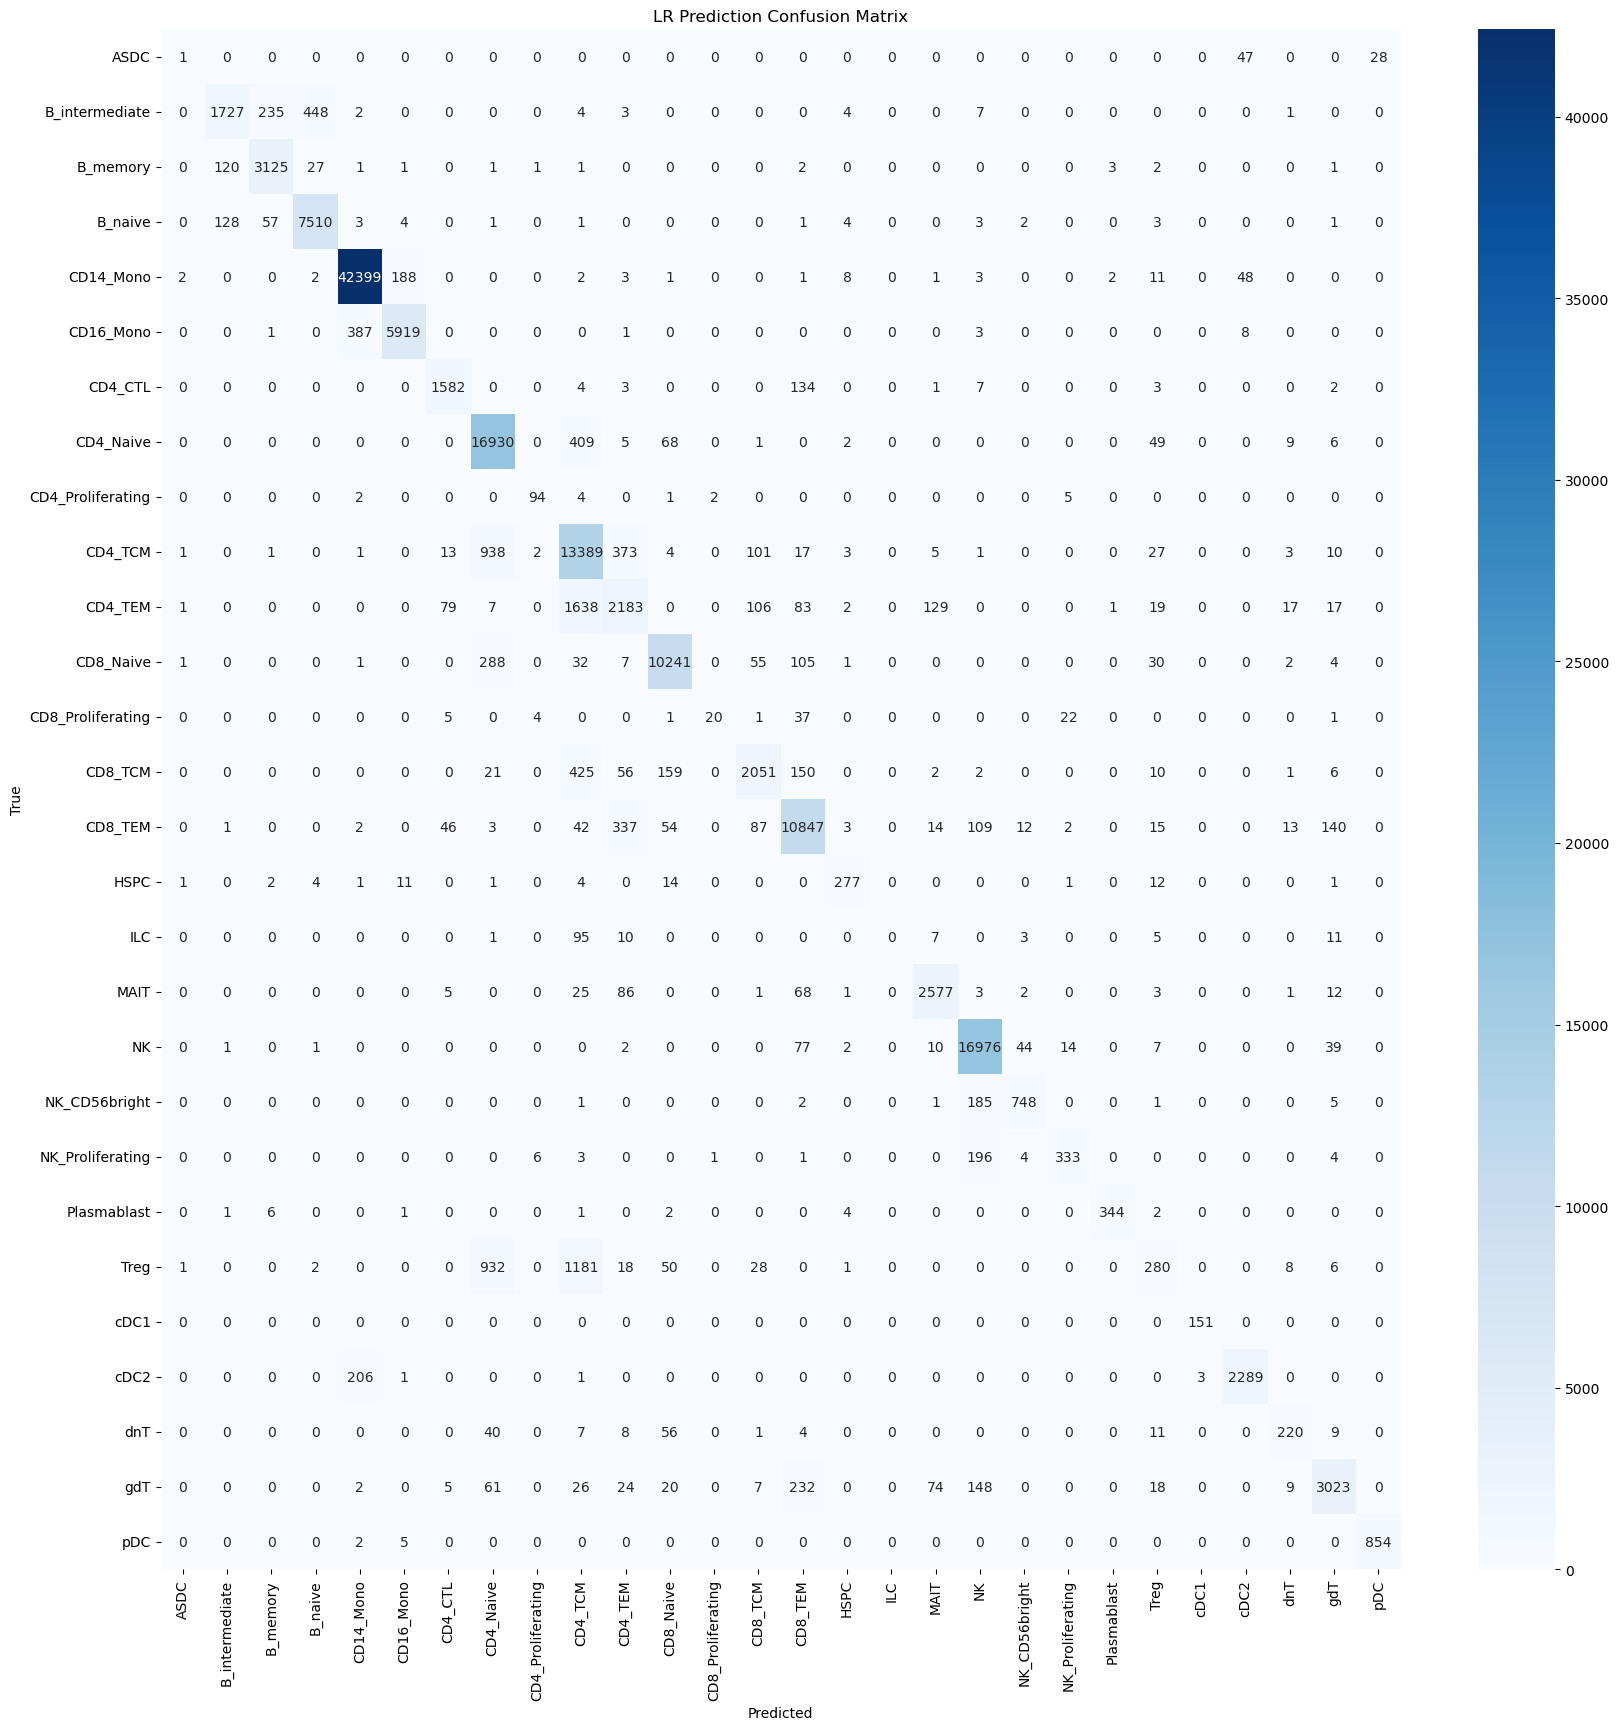

In [43]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(20, 20))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('LR Prediction Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()


In [44]:
row_sum = cm.sum(axis=1)


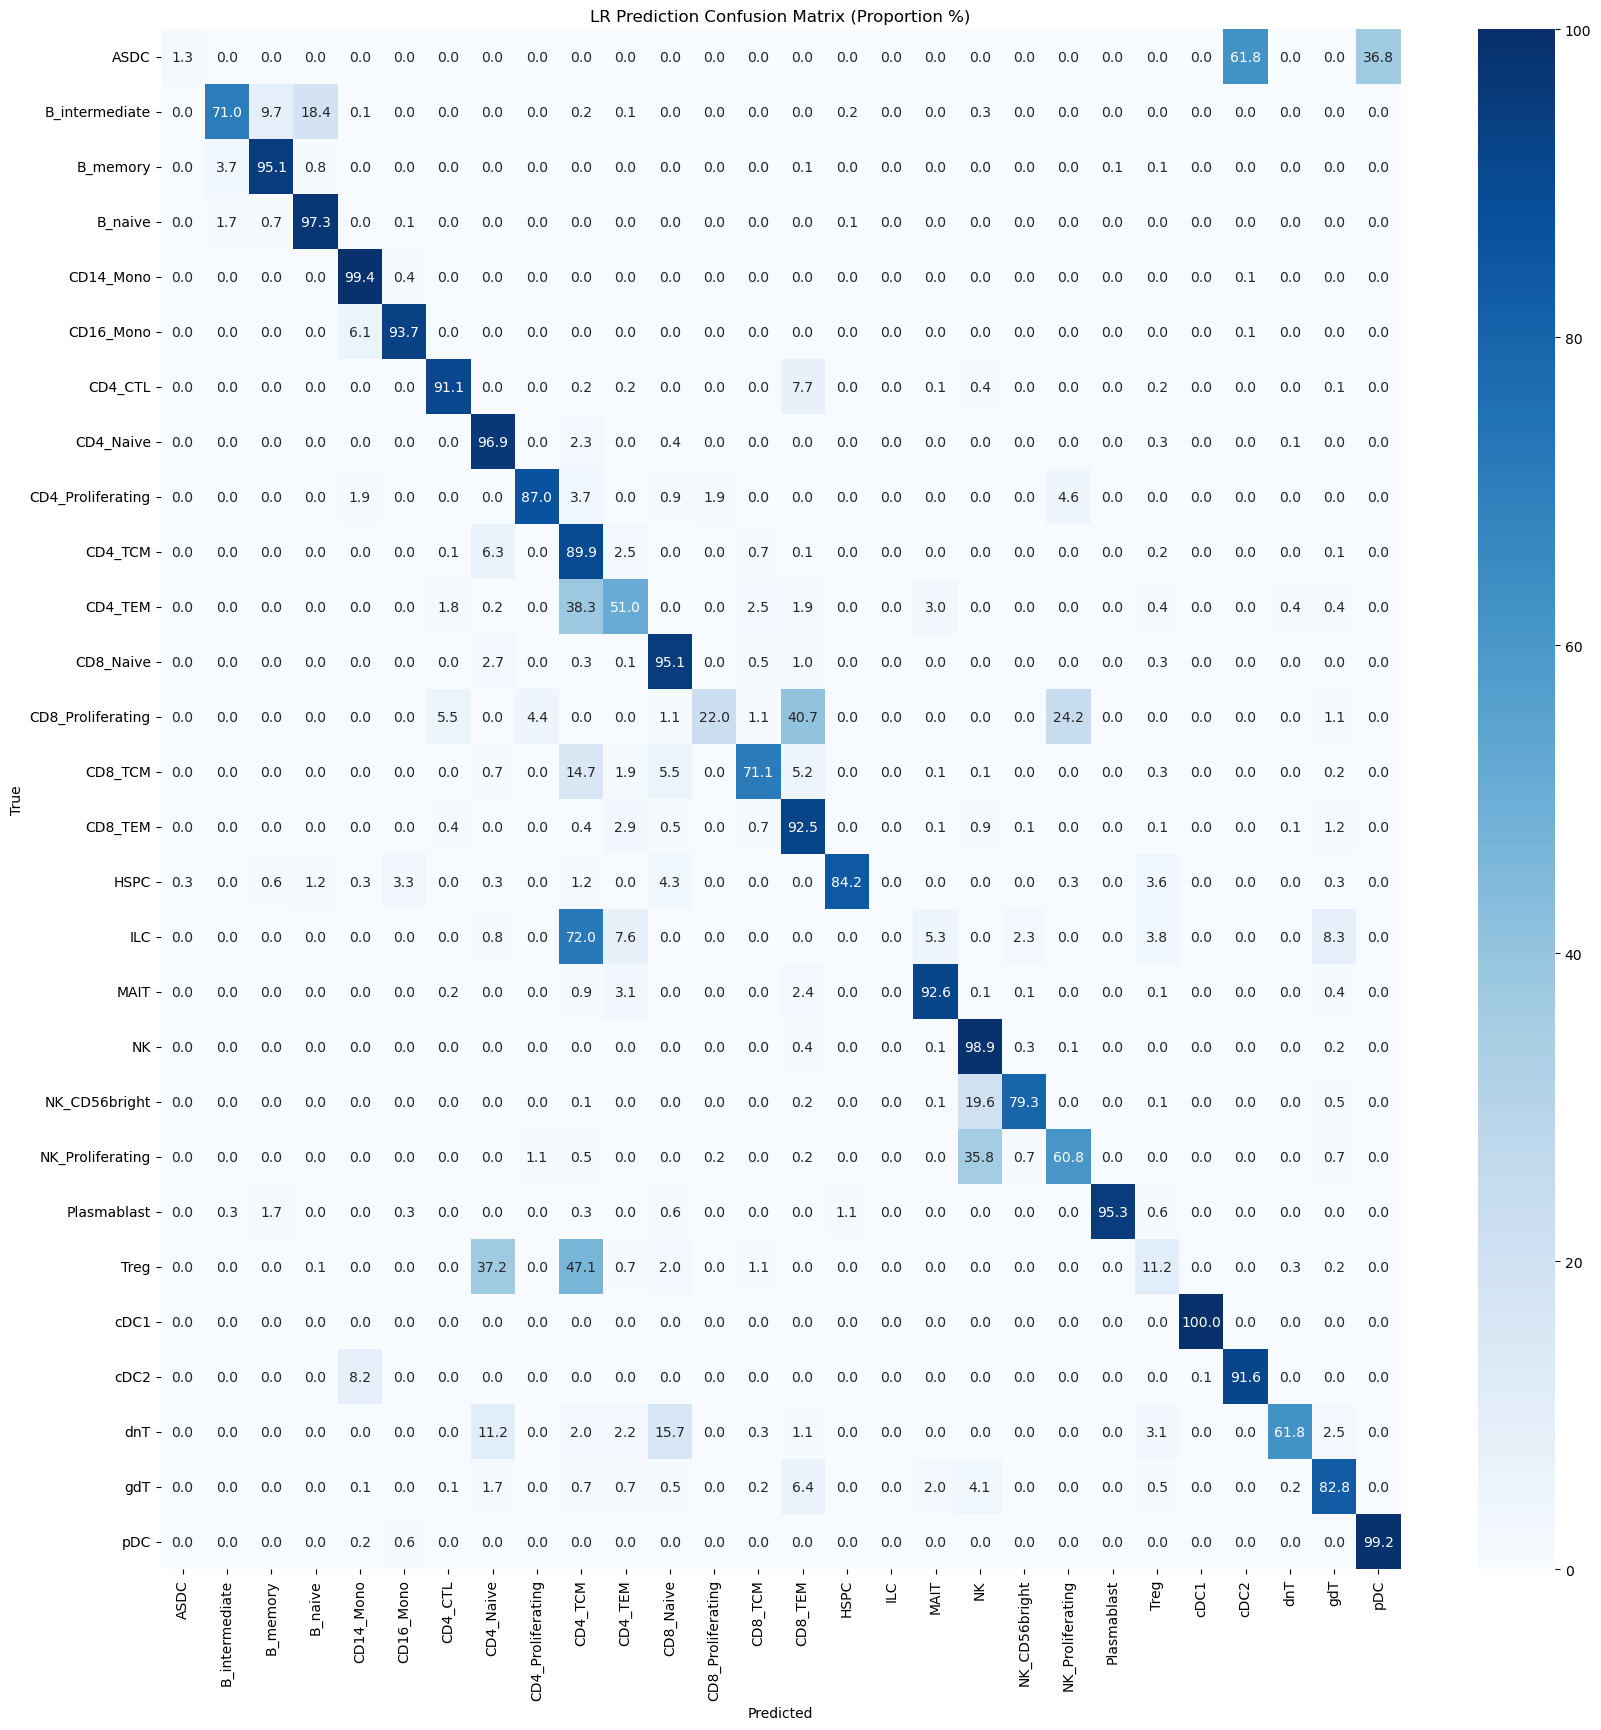

In [45]:
cm_proportion = cm.div(row_sum, axis=0)
cm_proportion *= 100
plt.figure(figsize=(20, 20))
sns.heatmap(cm_proportion, fmt=".1f", annot=True, cmap='Blues')
plt.title('LR Prediction Confusion Matrix (Proportion %)')
plt.show()